# IBM Employee attrition with RF & GBM

Attrition in human resources refers to the gradual loss of employees over time. In general, relatively high attrition is a form of loss for the employer. This notebook is for predicting employee attrition on this synthetically generated IBM dataset. I have constructed a very simple pipeline of predicting employee attrition, including some basic Exploratory Data Analysis, feature engineering as well as implementing two learning models in the form of a Random Forest (accuracy 87%) and a Gradient Boosting classifier (accuracy 88%).

### 1.Exploratory Data Analysis
### 2.Feature Engineering
### 3.Machine Learning models


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
import xgboost

## 1. Exploratory Data Analysis
Load the dataset by Pandas into a dataframe and have a glimpse of the first several rows.


In [2]:
data=pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# target variable frequencies in dataset
print("Number of No:")
print(data["Attrition"][data['Attrition']=="No"].count())
print("Number of Yes:")
print(data["Attrition"][data['Attrition']=="Yes"].count())

Number of No:
1233
Number of Yes:
237


In [4]:
#data completeness checks
data.isnull().any()

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

In [5]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
data["target_numerical"] = data["Attrition"].apply(lambda x: target_map[x])

In [6]:
# separate numerical and categorical variables
data_num=data.select_dtypes(include=['int64'])
data_cat=data.select_dtypes(include=['object'])

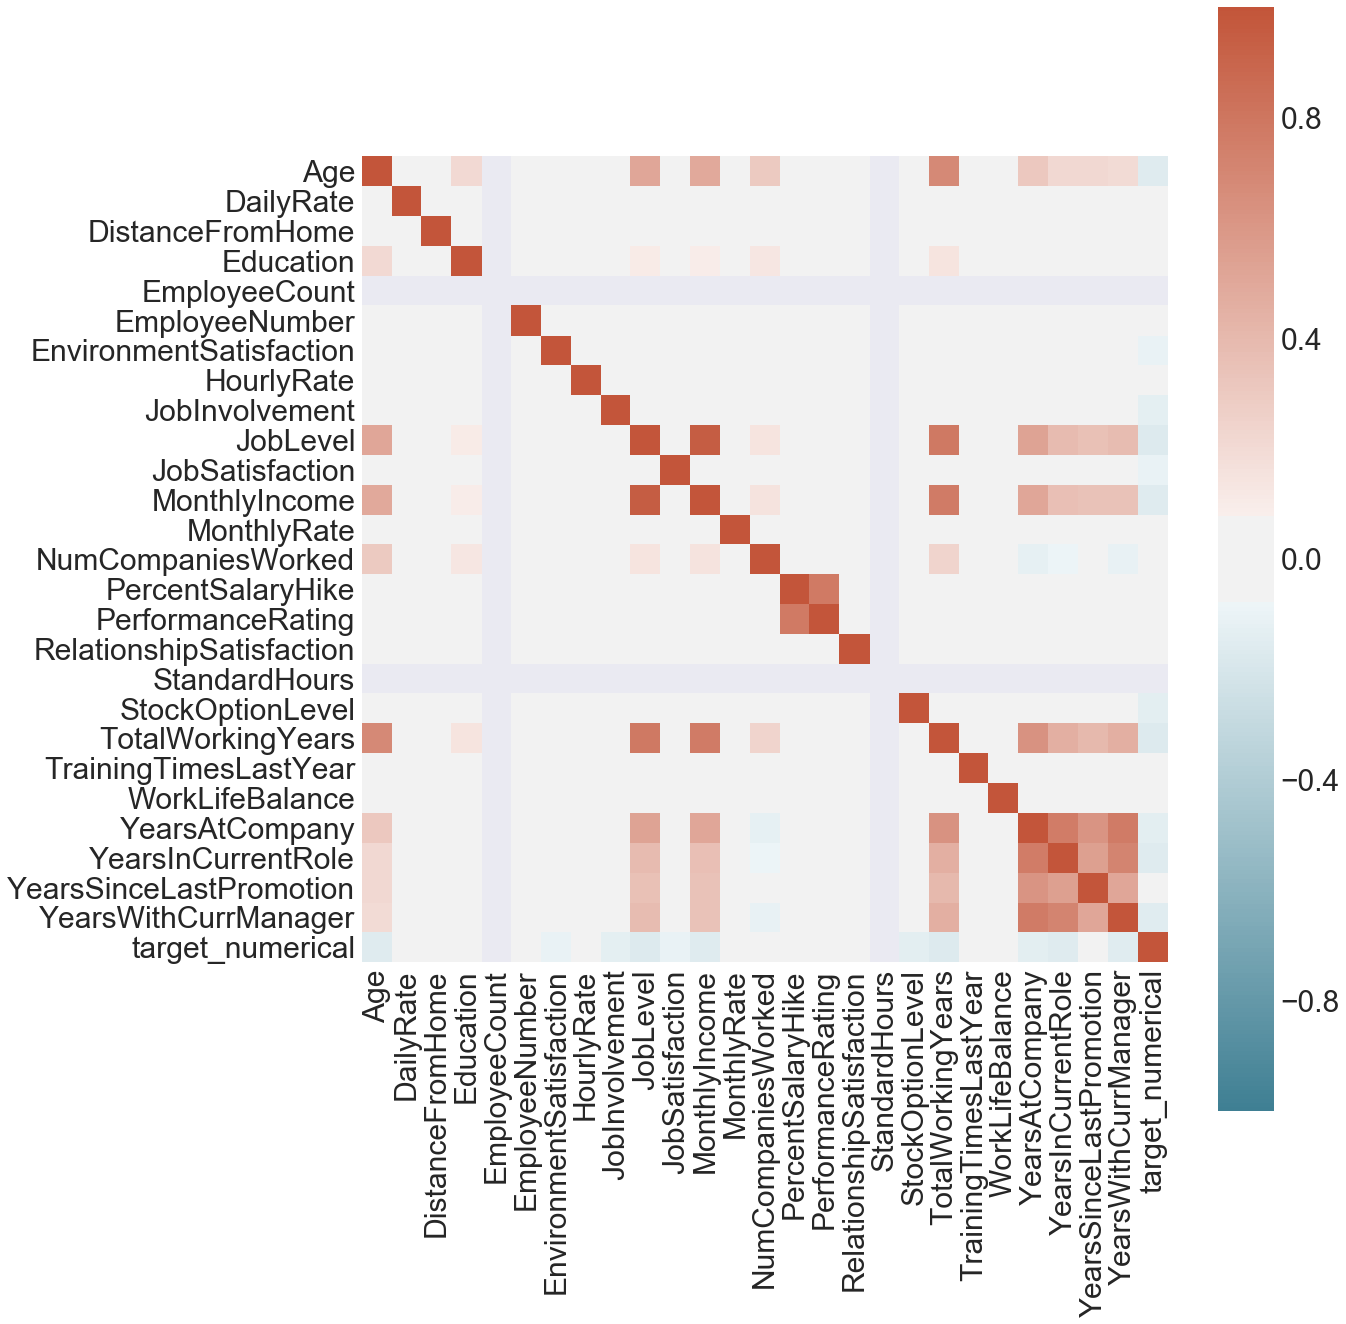

In [7]:
# correlation of numerical variables:
plt.figure(figsize=(20,20))
sns.set(font_scale=3.0)
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(data_num.corr(),square=True,cmap=cmap)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

There is not redundant features to deal with because most columns seem to be poorly correlated with one another. 

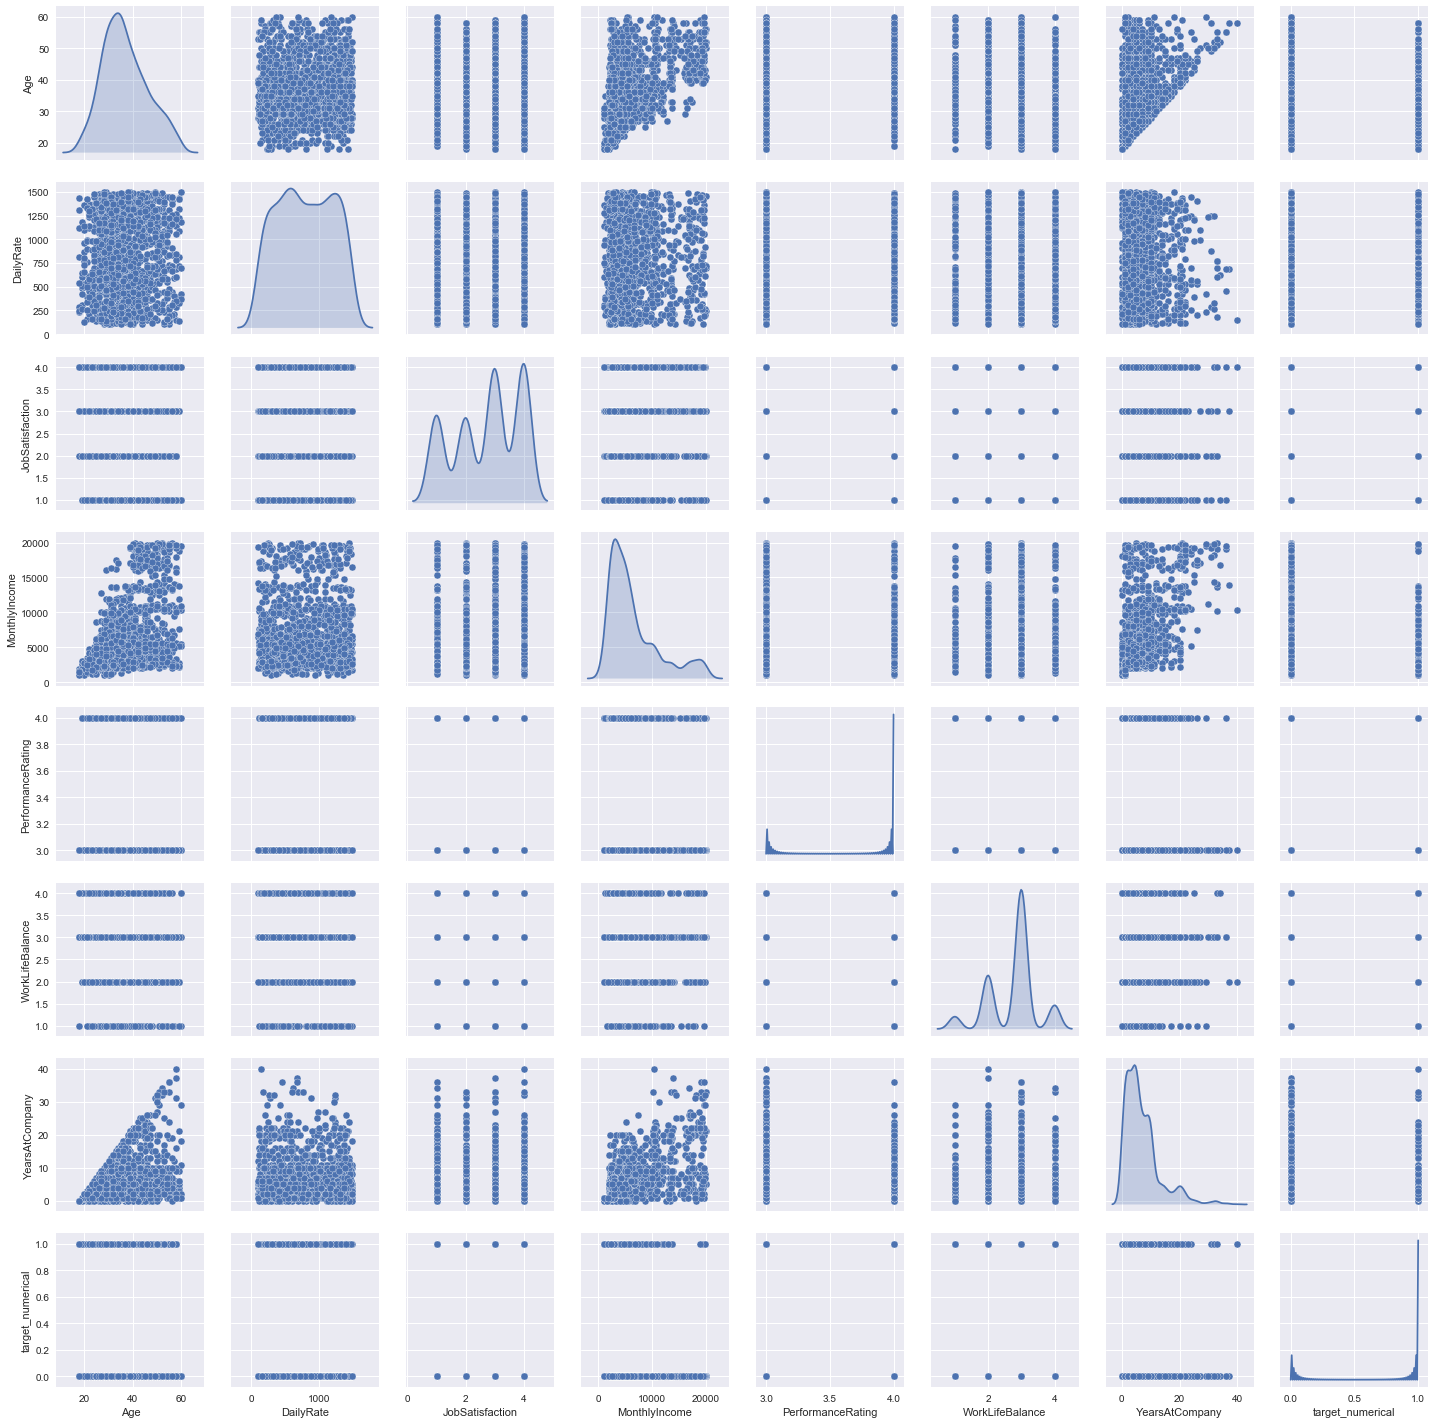

In [8]:
## pairplots for numerical variables and target variable
sns.set()
cols=[u'Age', u'DailyRate',  u'JobSatisfaction',
       u'MonthlyIncome', u'PerformanceRating',
        u'WorkLifeBalance', u'YearsAtCompany', u'target_numerical']
sns.pairplot(data[cols],size=2.5,palette='seismic', diag_kind = 'kde',diag_kws=dict(shade=True))
plt.show()

The pairplots above of several numerical variables against the target variable gives us a general idea of how the various features are distributed by employee attrition

## 2. Feature Engineering

We have segregated numberical columns from categorical columns based on dtype. I will use the get_dummies from Pandas to encode dummy variables from the categorical variables.


In [9]:
# list to store columns with categorical data
categorical=[]
for col, value in data.iteritems():
    if value.dtype=='object':
        categorical.append(col)
# list to store numerical columns 
numerical=data.columns.difference(categorical)
# Store the categorical data in a dataframe called data_cat
data_cat=data[categorical]
data_cat=data_cat.drop(["Attrition"],axis=1)
data_cat=pd.get_dummies(data_cat)
# Store the numerical data in a dataframe called data_num
data_num=data[numerical]
# Target variable
target=data["target_numerical"]
data_num=data_num.drop(["target_numerical"],axis=1)
# merge both dataframes into a final set with which we will train and test our models on.
data_final=pd.concat([data_num,data_cat],axis=1)
data_final.head(3)

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,41,1102,1,2,1,1,2,94,3,2,...,0,0,1,0,0,0,1,1,0,1
1,49,279,8,1,1,2,3,61,2,2,...,0,1,0,0,0,1,0,1,1,0
2,37,1373,2,2,1,4,4,92,2,1,...,0,0,0,0,0,0,1,1,0,1


In [10]:
target.head(3)

0    1
1    0
2    1
Name: target_numerical, dtype: int64

## 3. Machine Learning Models

### Train and test sets

In [11]:
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
train,test,target_train,target_val=train_test_split(data_final,target,
                                                    train_size=0.8,random_state=0)

### SMOTE to oversample 
It is noted that there is an issue of imbalance in the values within the target variable (the distribution of yes and no's are 84% and 26), we will implement the SMOTE method in the dealing with this skewed value via the imblearn Python package.

In [12]:
oversampler=SMOTE(random_state=0)
smote_train,smote_target=oversampler.fit_sample(train,target_train)

### Random Forest Classifier
The Random Forest method is a ensemble model built with a group Decision Trees. It has collective predictive capabilities of several decision trees so that it has better performance. I used Scikit-learn package to set up the model.

In [13]:
seed=0
# parameters
rf_params={
    'n_jobs': -1,
    'n_estimators': 800,
    'warm_start': True, 
    'max_features': 0.3,
    'max_depth': 9,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

In [14]:
## Set up the classifier and fit the model to the data set
rf = RandomForestClassifier(**rf_params)## **unpacking rf_params
rf.fit(smote_train,smote_target)

# Predict the test set using the same model
rf_predictions=rf.predict(test)
print("Accuracy:")
accuracy_score(target_val,rf_predictions)


Accuracy:


0.87755102040816324

Since the percentage of "yes" in the data set is 84%, an accuracy of 88% is just slightly better than random guessing.

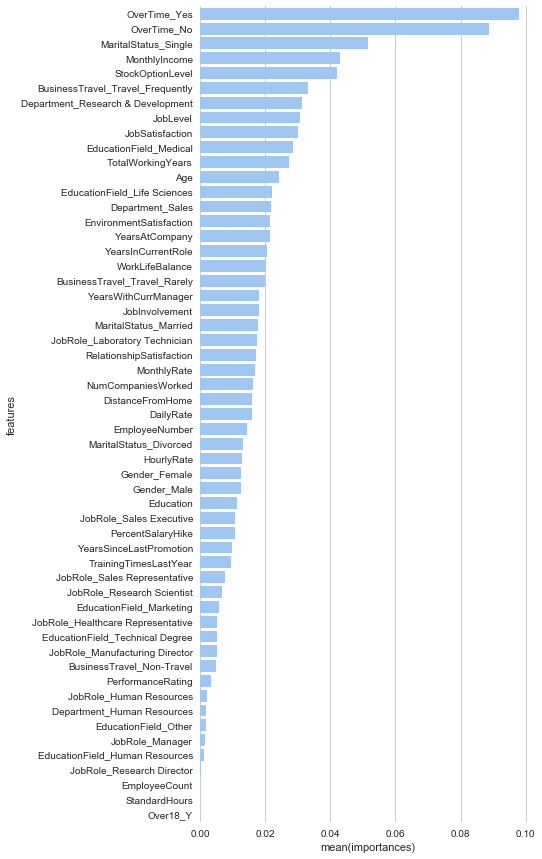

In [15]:
# Feature Ranking
pldata=pd.DataFrame(data=rf.feature_importances_,columns=["importances"])
pldata["features"]=data_final.columns
pldata=pldata.sort_values("importances",ascending=False)
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.set_color_codes("pastel")
sns.barplot(x="importances", y="features", data=pldata,
            label="importances", color="b")
sns.despine(left=True, bottom=True)

As is observed in the plot of feature ranking, the top three important features according to RF are "overtime", "marital status" and "monthly income".

### Gradient Boosted Classifier

In [16]:
seed=0

gb_params ={
    'n_estimators': 500,
    'max_features': 0.9,
    'learning_rate' : 0.2,
    'max_depth': 11,
    'min_samples_leaf': 2,
    'subsample': 1,
    'max_features' : 'sqrt',
    'random_state' : seed,
    'verbose': 0
}

In [17]:
gb = GradientBoostingClassifier(**gb_params)
# Fit the model to our SMOTEd train and target data set
gb.fit(smote_train, smote_target)
# Get our predictions
gb_predictions = gb.predict(test)
print("Accuracy:")
print(accuracy_score(target_val, gb_predictions))

Accuracy:
0.87074829932


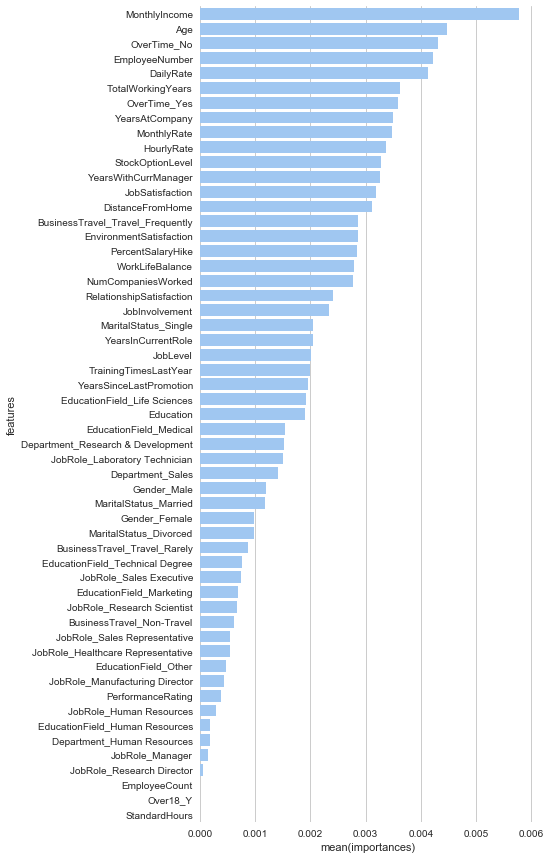

In [18]:
# feature ranking
pldata=pd.DataFrame(data=gb.feature_importances_,columns=["importances"])
pldata["features"]=data_final.columns
pldata=pldata.sort_values("importances",ascending=False)
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.set_color_codes("pastel")
sns.barplot(x="importances", y="features", data=pldata,
            label="importances", color="b")
sns.despine(left=True, bottom=True)

We found that "EmployeeNumber" is ranked high in the importance order, which is not reasonable. Let's see how Gradient Boosted Classifier would perform without EmployeeNumber.

In [19]:
data_final=data_final.drop('EmployeeNumber',1)
train,test,target_train,target_val=train_test_split(data_final,target,
                                                    train_size=0.8,random_state=0)
#SMOTE oversample
oversampler=SMOTE(random_state=0)
smote_train,smote_target=oversampler.fit_sample(train,target_train)

In [20]:
# Fit the model to our SMOTEd train and target data set
gb.fit(smote_train, smote_target)
# Get our predictions
gb_predictions = gb.predict(test)
print("Accuracy:")
print(accuracy_score(target_val, gb_predictions))

Accuracy:
0.880952380952


The accuracy of Gradient Boosted Classifier increases from 0.87 to 0.88.

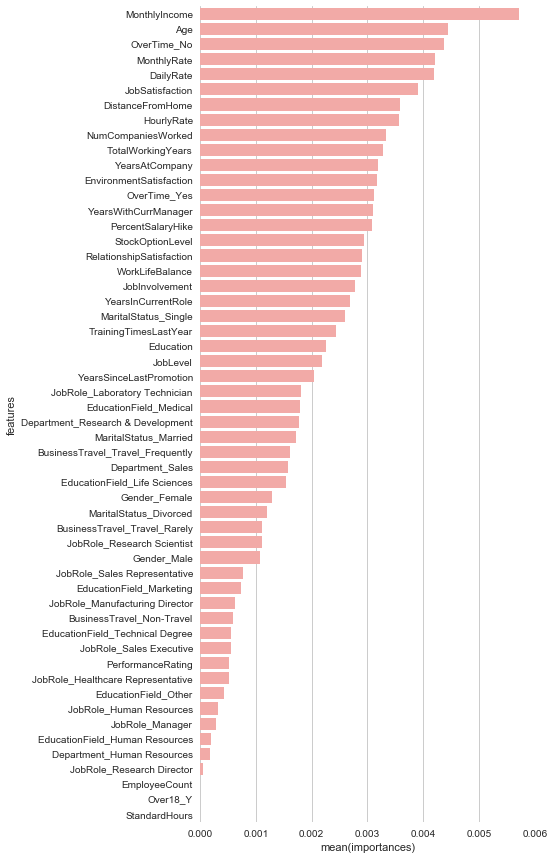

In [21]:
# feature ranking
pldata=pd.DataFrame(data=gb.feature_importances_,columns=["importances"])
pldata["features"]=data_final.columns
pldata=pldata.sort_values("importances",ascending=False)
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.set_color_codes("pastel")
sns.barplot(x="importances", y="features", data=pldata,
            label="importances", color="r")
sns.despine(left=True, bottom=True)

As is observed in the plot of feature ranking, the top three important features according to Gradient Boosted Classifier are "monthly income", "age" and "overtime".